In [1]:
import pandas as pd
from os import path
import matplotlib.pyplot as plt
from scipy import signal, interpolate
import numpy as np
import folium


In [2]:
source_path = r"C:\Users\joses\Mi unidad\TRABAJO\49_profile_estimation\TRABAJO\experimental\bus_913"

win_len = 500

speed_stopped_th = 1. # m/s

# Data Extraction

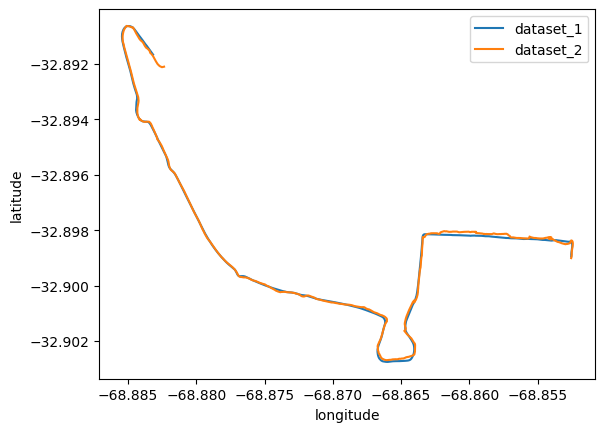

In [3]:
subtract_g = True
fs_acc = 100 # sps

# Dataset 1
i_ini, i_fin = 60, 800 # s
acc_orig_df_1 = pd.read_csv(path.join(source_path, "913_1/AccelerometerUncalibrated.csv")).iloc[i_ini*fs_acc:i_fin*fs_acc, :].reset_index()
if subtract_g:
    acc_orig_df_1['z'] = acc_orig_df_1['z'] - 9.81
loc_orig_df_1 = pd.read_csv(path.join(source_path, "913_1/Location.csv")).iloc[i_ini:i_fin, :].reset_index()
loc_orig_df_1 = loc_orig_df_1.loc[loc_orig_df_1['speed'] > speed_stopped_th].reset_index()

# Dataset 2
i_ini, i_fin = 0, 800 # s
acc_orig_df_2 = pd.read_csv(path.join(source_path, "913_2/AccelerometerUncalibrated.csv")).iloc[i_ini*fs_acc:i_fin*fs_acc, :].reset_index()
if subtract_g:
    acc_orig_df_2['z'] = acc_orig_df_2['z'] - 9.81
loc_orig_df_2 = pd.read_csv(path.join(source_path, "913_2/Location.csv")).iloc[i_ini:i_fin, :].reset_index()
loc_orig_df_2 = loc_orig_df_2.loc[loc_orig_df_2['speed'] > speed_stopped_th].reset_index()

plt.plot(loc_orig_df_1['longitude'], loc_orig_df_1['latitude'], label='dataset_1')
plt.plot(loc_orig_df_2['longitude'], loc_orig_df_2['latitude'], label='dataset_2')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()
plt.show()

## Raw Visualization

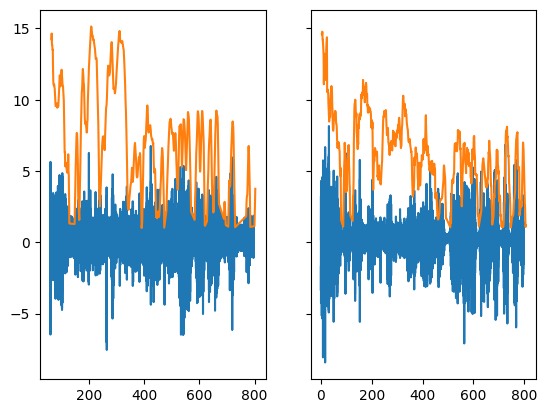

In [4]:
fig, ax = plt.subplots(1, 2, sharey='row')
ax[0].plot(acc_orig_df_1['seconds_elapsed'], acc_orig_df_1['z'])
ax[0].plot(loc_orig_df_1['seconds_elapsed'], loc_orig_df_1['speed'])
ax[1].plot(acc_orig_df_2['seconds_elapsed'], acc_orig_df_2['z'])
ax[1].plot(loc_orig_df_2['seconds_elapsed'], loc_orig_df_2['speed'])

# Feature extraction

In [5]:
def rms(arr):
    return np.sqrt(np.mean(arr**2))

acc_feat_df_1 = pd.DataFrame(data=np.vstack((acc_orig_df_1['seconds_elapsed'].values, acc_orig_df_1['z'].rolling(win_len).apply(rms).values)).T, 
                             columns=['seconds_elapsed', 'z_rolling_rms'])
acc_feat_df_1.reset_index(inplace=True)
acc_feat_df_2 = pd.DataFrame(data=np.vstack((acc_orig_df_2['seconds_elapsed'].values, acc_orig_df_2['z'].rolling(win_len).apply(rms).values)).T, 
                             columns=['seconds_elapsed', 'z_rolling_rms'])
acc_feat_df_2.reset_index(inplace=True)


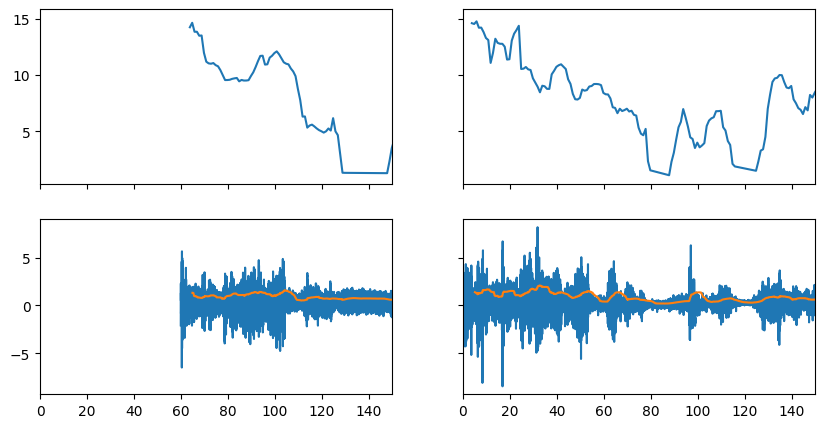

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='all', sharey='row')
ax[0,0].plot(loc_orig_df_1['seconds_elapsed'], loc_orig_df_1['speed'])
ax[1,0].plot(acc_orig_df_1['seconds_elapsed'], acc_orig_df_1['z'])
ax[1,0].plot(acc_feat_df_1['seconds_elapsed'], acc_feat_df_1['z_rolling_rms'])
# ax[1,0].set_xlim([0, 200])
ax[0,1].plot(loc_orig_df_2['seconds_elapsed'], loc_orig_df_2['speed'])
ax[1,1].plot(acc_orig_df_2['seconds_elapsed'], acc_orig_df_2['z'])
ax[1,1].plot(acc_feat_df_2['seconds_elapsed'], acc_feat_df_2['z_rolling_rms'])
ax[1,1].set_xlim([0, 150])
plt.show()


### Scatter analysis

#### Low frequency

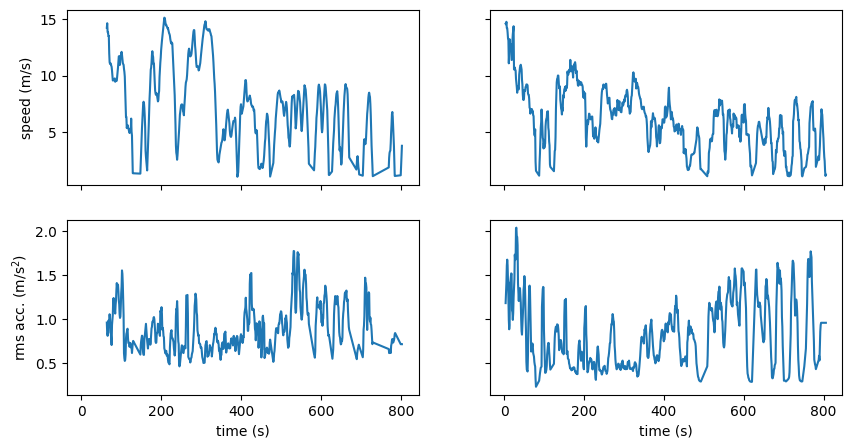

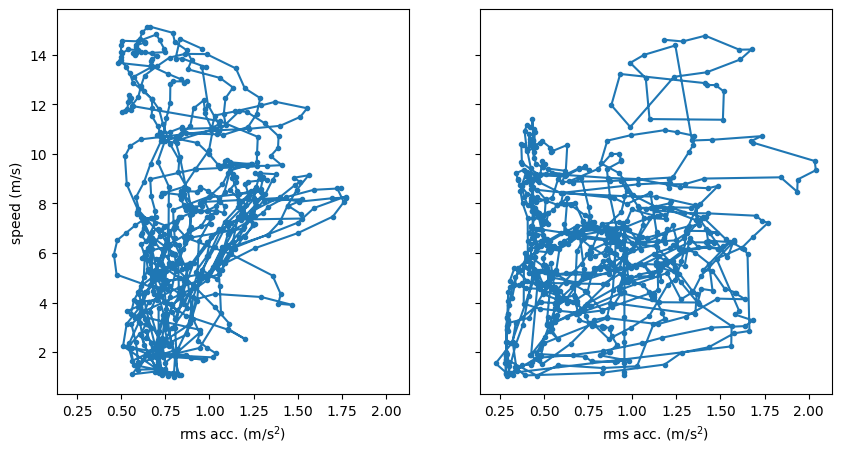

In [7]:
features_lf_1 = loc_orig_df_1.loc[:,:]
features_lf_1['z_rolling_rms'] = np.interp(x=loc_orig_df_1['seconds_elapsed'], 
                                           xp=acc_feat_df_1['seconds_elapsed'].values-((win_len/fs_acc)/2), fp=acc_feat_df_1['z_rolling_rms'])
features_lf_1 = features_lf_1.drop(columns=['level_0']).reset_index()
features_lf_2 = loc_orig_df_2.loc[:,:]
features_lf_2['z_rolling_rms'] = np.interp(x=loc_orig_df_2['seconds_elapsed'], 
                                           xp=acc_feat_df_2['seconds_elapsed'].values-((win_len/fs_acc)/2), fp=acc_feat_df_2['z_rolling_rms'])
features_lf_2 = features_lf_2.drop(columns=['level_0']).reset_index()

fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='all', sharey='row')
ax[0,0].plot(features_lf_1['seconds_elapsed'], features_lf_1['speed'])
ax[0,0].set_ylabel('speed (m/s)')
ax[1,0].plot(features_lf_1['seconds_elapsed'], features_lf_1['z_rolling_rms'])
# ax[1,1].set_ylabel('rms acc. (m/s$^2$)')
ax[0,1].plot(features_lf_2['seconds_elapsed'], features_lf_2['speed'])
# ax[0,1].set_ylabel('speed (m/s)')
ax[1,1].plot(features_lf_2['seconds_elapsed'], features_lf_2['z_rolling_rms'])
ax[1,0].set_ylabel('rms acc. (m/s$^2$)')
ax[1,0].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)')

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex='all', sharey='all')
ax[0].plot(features_lf_1['z_rolling_rms'], features_lf_1['speed'], linestyle='-', marker='.')
ax[0].set_xlabel('rms acc. (m/s$^2$)')
ax[0].set_ylabel('speed (m/s)')
ax[1].plot(features_lf_2['z_rolling_rms'], features_lf_2['speed'], linestyle='-', marker='.')
ax[1].set_xlabel('rms acc. (m/s$^2$)')
plt.show()

### Location matching

In [8]:
from scipy.spatial.distance import cdist


# Extract coordinates as arrays
coords_orig = loc_orig_df_1[['latitude', 'longitude']].values
coords_dest = loc_orig_df_2[['latitude', 'longitude']].values

# Compute pairwise distances
distances = cdist(coords_orig, coords_dest, metric='euclidean')

# Find the nearest point for each origin point
nearest_indices = distances.argmin(axis=1)
nearest_distances = distances.min(axis=1)

# Build a dictionary of time matches
time_matches_dict = {}
for i, (dist, idx) in enumerate(zip(nearest_distances, nearest_indices)):
    orig_time = loc_orig_df_1.iloc[i]['seconds_elapsed']
    dest_time = loc_orig_df_2.iloc[idx]['seconds_elapsed']
    time_matches_dict[orig_time] = dest_time


# time_matches_dict = dict(time_matches)


In [9]:
# from geopy import distance


# # time matching
# time_matches_dict = {}
# for index, row in loc_orig_df_1.iterrows():
#     lat_lon = np.array([row['latitude'], row['longitude']])
#     min_dist = (np.inf, np.nan)
#     for index_, row_ in loc_orig_df_2.iterrows():
#         lat_lon_ = np.array([row_['latitude'], row_['longitude']])
#         if index != index_:
#             dist = distance.distance(lat_lon, lat_lon_).km
#             if dist < min_dist[0]:
#                 min_dist = (dist, row_['seconds_elapsed'])
#     time_matches_dict.update({row['seconds_elapsed']: min_dist[1]})



Text(0.5, 0, 'time (s)')

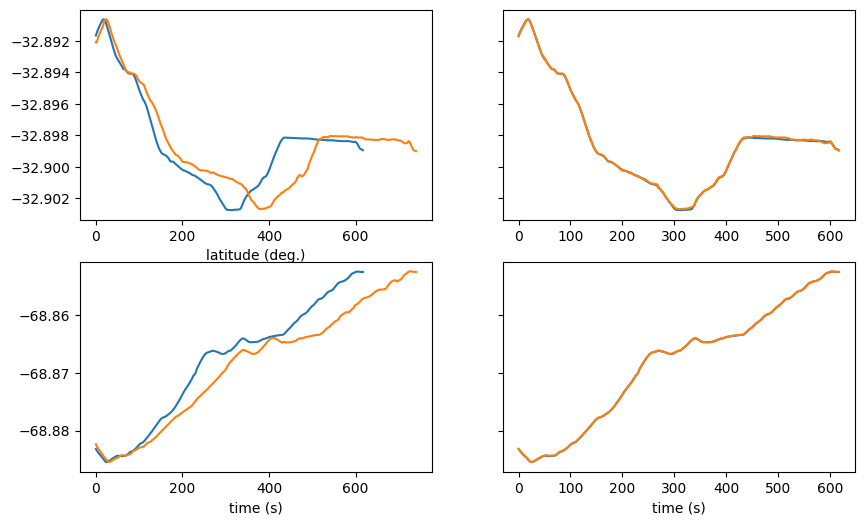

In [10]:
# location matching
loc_orig_df_2_matched = loc_orig_df_1.copy()
for index, row in loc_orig_df_1.iterrows():
    seconds_elapsed_1 = row['seconds_elapsed']
    if index == len(loc_orig_df_2_matched):
        break
    loc_orig_df_2_matched.iloc[index] = loc_orig_df_2.loc[loc_orig_df_2['seconds_elapsed'] == time_matches_dict[seconds_elapsed_1]].values[0]
    
fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharey='row')
ax[0,0].plot(loc_orig_df_1['latitude'].values)
ax[0,0].plot(loc_orig_df_2['latitude'].values)
ax[1,0].plot(loc_orig_df_1['longitude'].values)
ax[1,0].plot(loc_orig_df_2['longitude'].values)


ax[0,1].plot(loc_orig_df_1['latitude'].values)
ax[0,1].plot(loc_orig_df_2_matched['latitude'].values)
ax[1,1].plot(loc_orig_df_1['longitude'].values)
ax[1,1].plot(loc_orig_df_2_matched['longitude'].values)

ax[0,0].set_xlabel('latitude (deg.)')
ax[1,0].set_xlabel('longitude (deg.)')
ax[1,0].set_xlabel('time (s)')
ax[1,1].set_xlabel('time (s)')

# Training

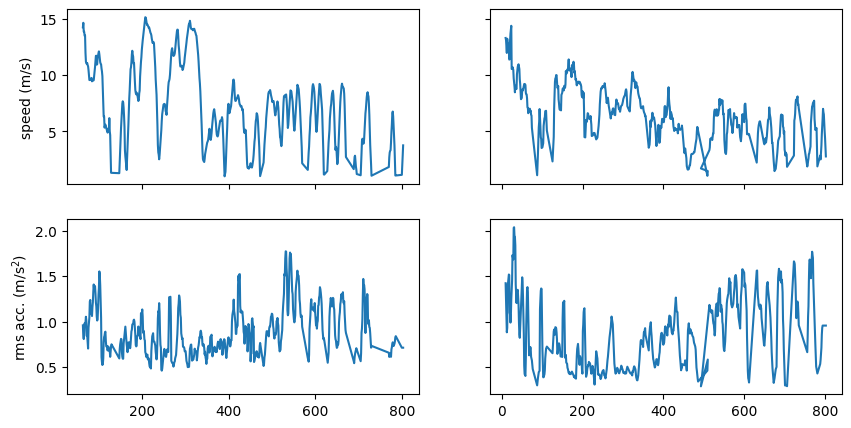

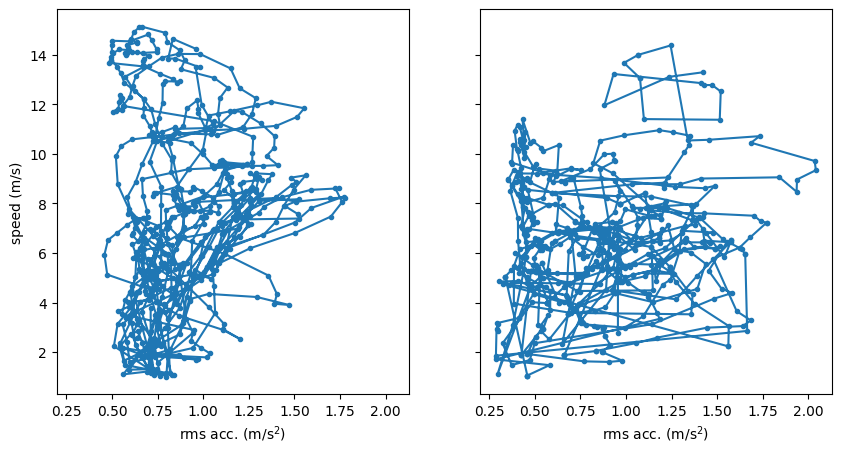

In [11]:
# feature matching
features_lf_2_matched = features_lf_1.copy()
for index, row in features_lf_1.iterrows():
    seconds_elapsed_1 = row['seconds_elapsed']
    features_lf_2_matched.iloc[index] = features_lf_2.loc[features_lf_2['seconds_elapsed'] == time_matches_dict[seconds_elapsed_1]].values[0]

fig, ax = plt.subplots(2, 2, figsize=(10, 5), sharex='col', sharey='row')
ax[0,0].plot(features_lf_1['seconds_elapsed'], features_lf_1['speed'])
ax[0,0].set_ylabel('speed (m/s)')
ax[1,0].plot(features_lf_1['seconds_elapsed'], features_lf_1['z_rolling_rms'])
# ax[1,1].set_ylabel('rms acc. (m/s$^2$)')
ax[0,1].plot(features_lf_2_matched['seconds_elapsed'], features_lf_2_matched['speed'])
# ax[0,1].set_ylabel('speed (m/s)')
ax[1,1].plot(features_lf_2_matched['seconds_elapsed'], features_lf_2_matched['z_rolling_rms'])
ax[1,0].set_ylabel('rms acc. (m/s$^2$)')
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex='all', sharey='all')
ax[0].plot(features_lf_1['z_rolling_rms'], features_lf_1['speed'], linestyle='-', marker='.')
ax[0].set_xlabel('rms acc. (m/s$^2$)')
ax[0].set_ylabel('speed (m/s)')
ax[1].plot(features_lf_2_matched['z_rolling_rms'], features_lf_2_matched['speed'], linestyle='-', marker='.')
ax[1].set_xlabel('rms acc. (m/s$^2$)')
plt.show()

### Datasets

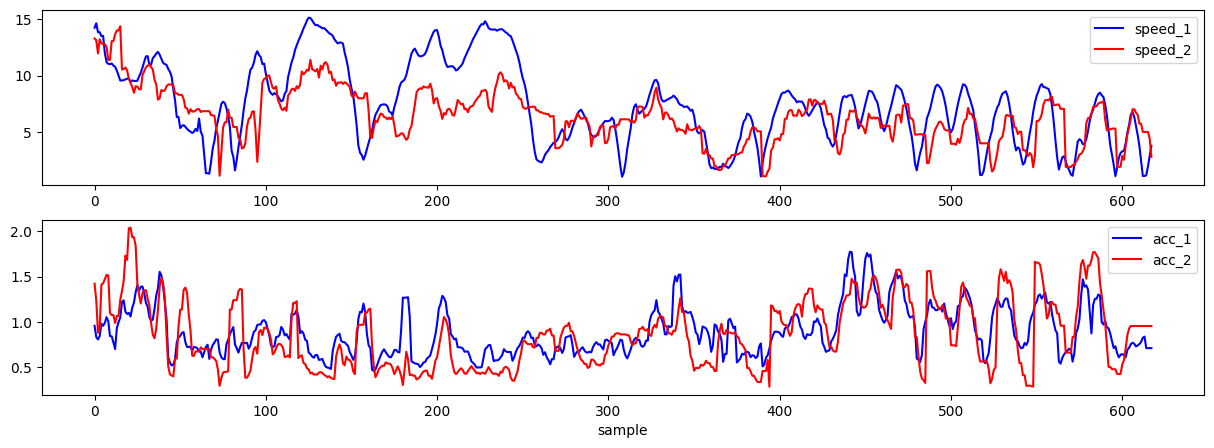

In [12]:
X_equal = np.array([features_lf_1.loc[:, 'speed'].values, features_lf_1.loc[:, 'z_rolling_rms'].values, 
                    features_lf_2_matched.loc[:, 'speed'].values, features_lf_2_matched.loc[:, 'z_rolling_rms'].values]).T
y_equal = np.zeros((X_equal.shape[0], 1))

fig, ax = plt.subplots(2, 1, figsize=(15,5))
ax[0].plot(X_equal[:, 0], color='blue', linestyle='-', label='speed_1')
ax[0].plot(X_equal[:, 2], color='red', linestyle='-', label='speed_2')
ax[0].legend()
ax[1].plot(X_equal[:, 1], color='blue', linestyle='-', label='acc_1')
ax[1].plot(X_equal[:, 3], color='red', linestyle='-', label='acc_2')
ax[1].set_xlabel('sample')
ax[1].legend()


#### Ordinal labels

In [13]:
from sklearn.model_selection import train_test_split


(array([ 7.,  0.,  0.,  0.,  0., 26.,  0.,  0.,  0., 16.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

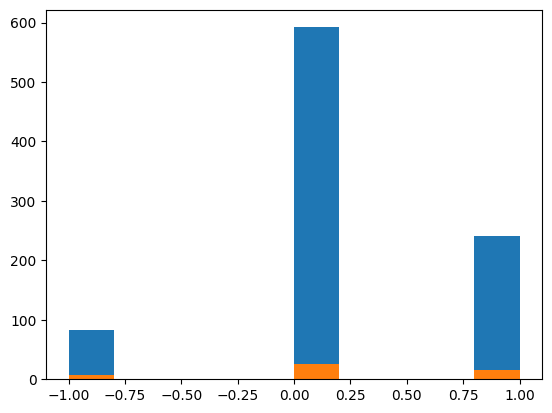

In [14]:
speed_tol = 0.5 # m/s
acc_tol = 1.1 # 1.2 # m/s2

X_ordinal = []
y_ordinal = []
for x1 in X_equal[:, :2]:
    for x2 in X_equal[:, 2:]:
        if abs(x1[0] - x2[0]) < speed_tol:
            if x1[1] > x2[1] + acc_tol:
                X_ordinal.append(np.hstack((x1, x2)))
                y_ordinal.append(1.)
            elif x1[1] < x2[1] - acc_tol:
                X_ordinal.append(np.hstack((x1, x2)))
                y_ordinal.append(-1.)
X_ordinal = np.array(X_ordinal)
y_ordinal = np.array(y_ordinal).reshape((-1, 1))

X = np.vstack((X_equal, X_ordinal))
y = np.vstack((y_equal, y_ordinal))
shuffler = np.arange(X.shape[0])
np.random.default_rng().shuffle(shuffler)
X = X[shuffler, :]
y = y[shuffler, :]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=True)

plt.hist(y_train)
plt.hist(y_test)

## Model definition

In [15]:
import keras


x1_nn_input = keras.layers.Input(shape=(2,))
x2_nn_input = keras.layers.Input(shape=(2,))

activation = 'tanh'
reg = 'l2'
dropout = 0.1
shared_layers = [
                #  keras.layers.Dense(64, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                #  keras.layers.Dense(32, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                #  keras.layers.Dense(16, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                #  keras.layers.Dropout(dropout),
                #  keras.layers.BatchNormalization(),
                 keras.layers.Dense(8, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                 keras.layers.Dropout(dropout),
                 keras.layers.BatchNormalization(),
                 keras.layers.Dense(4, activation=activation, kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg),
                 keras.layers.Dropout(dropout),
                 keras.layers.BatchNormalization(),
                 keras.layers.Dense(1, activation='linear', kernel_regularizer=reg, bias_regularizer=reg, activity_regularizer=reg)]
first = True
for layer in shared_layers:
    if first:
        x1_nn = layer(x1_nn_input)
        x2_nn = layer(x2_nn_input)
        first = False    
    else:
        x1_nn = layer(x1_nn)
        x2_nn = layer(x2_nn)

y_nn = keras.layers.Lambda(lambda x12: keras.backend.tanh(x12[0] - x12[1]), name='ranker')((x1_nn, x2_nn))

model = keras.models.Model(inputs=[x1_nn_input, x2_nn_input], outputs=[y_nn])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 8)                    24        ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 8)                    0         ['dense[0][0]',           

In [16]:
model_x1 = keras.models.Model(inputs=[x1_nn_input], outputs=[x1_nn])
model_x1.build(input_shape=x1_nn_input.shape)
# model_x1.summary()

## Model training

Epoch 1/300
1/1 [==============================] - 3s 3s/step - loss: 1.2891 - val_loss: 0.7178 - lr: 0.5000
Epoch 2/300
1/1 [==============================] - 0s 47ms/step - loss: 1.3241 - val_loss: 0.7153 - lr: 0.5000
Epoch 3/300
1/1 [==============================] - 0s 49ms/step - loss: 0.9486 - val_loss: 0.7038 - lr: 0.5000
Epoch 4/300
1/1 [==============================] - 0s 49ms/step - loss: 0.9058 - val_loss: 0.6886 - lr: 0.5000
Epoch 5/300
1/1 [==============================] - 0s 46ms/step - loss: 0.7380 - val_loss: 0.6848 - lr: 0.5000
Epoch 6/300
1/1 [==============================] - 0s 49ms/step - loss: 0.7414 - val_loss: 0.6784 - lr: 0.5000
Epoch 7/300
1/1 [==============================] - 0s 48ms/step - loss: 0.6808 - val_loss: 0.6785 - lr: 0.5000
Epoch 8/300
1/1 [==============================] - 0s 45ms/step - loss: 0.8180 - val_loss: 0.6704 - lr: 0.5000
Epoch 9/300
1/1 [==============================] - 0s 47ms/step - loss: 0.6775 - val_loss: 0.6648 - lr: 0.5000
Epo

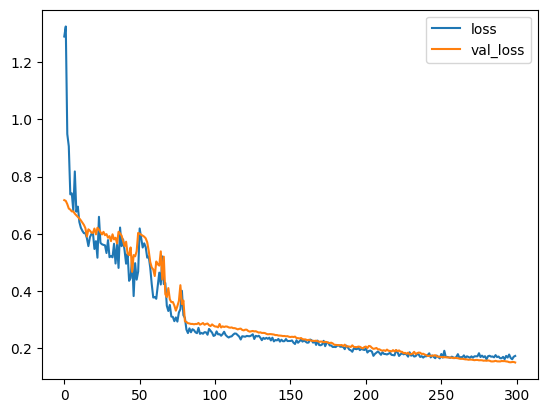

In [17]:
learning_rate = .5
batch_size = X_train.shape[0]
epochs = 300
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7,
                                              patience=5, verbose=1,min_lr=0)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100,)

model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss='mse')
history = model.fit(x=[X_train[:, :2], X_train[:, 2:]], y=[y_train], batch_size=batch_size, epochs=epochs, 
                    validation_split=0.9,
                    callbacks=[reduce_lr, early_stopping])
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Test

In [18]:
import plotly.graph_objects as go


layout = go.Layout(width=800, height=600)
x1_nn_train_pred = model_x1.predict([X_train[:, :2]])
fig3 = go.Figure(data=go.Scatter3d(x=X_train[:, 0], y=X_train[:, 1], z=x1_nn_train_pred[:,0],
                                   mode='markers', marker=dict(size=5), name='train'), layout=layout)

x1_nn_test_pred = model_x1.predict([X_test[:, :2]])
fig3.add_trace(go.Scatter3d(x=X_test[:, 0], y=X_test[:, 1], z=x1_nn_test_pred[:,0],
                            mode='markers', marker=dict(size=5), name='test'))
fig3.show()

layout = go.Layout(width=800, height=600)
X1_mesh, X2_mesh = np.meshgrid(np.linspace(0., 15., 20), np.linspace(0., 2.5, 20))
x1_mesh, x2_mesh = np.ravel(X1_mesh).reshape((-1, 1)), np.ravel(X2_mesh).reshape((-1, 1))
X1_mesh = np.hstack((x1_mesh, x2_mesh))
y_mesh = model_x1.predict([X1_mesh])
fig4 = go.Figure(data=go.Scatter3d(x=x1_mesh.ravel(), y=x2_mesh.ravel(), z=y_mesh.ravel(),
                                   mode='markers', marker=dict(size=5)), layout=layout)
fig4.show()


2/2 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 2ms/step


## Robustness testing

20/20 [==============================] - 0s 2ms/step


Text(0.5, 0, 'sample')

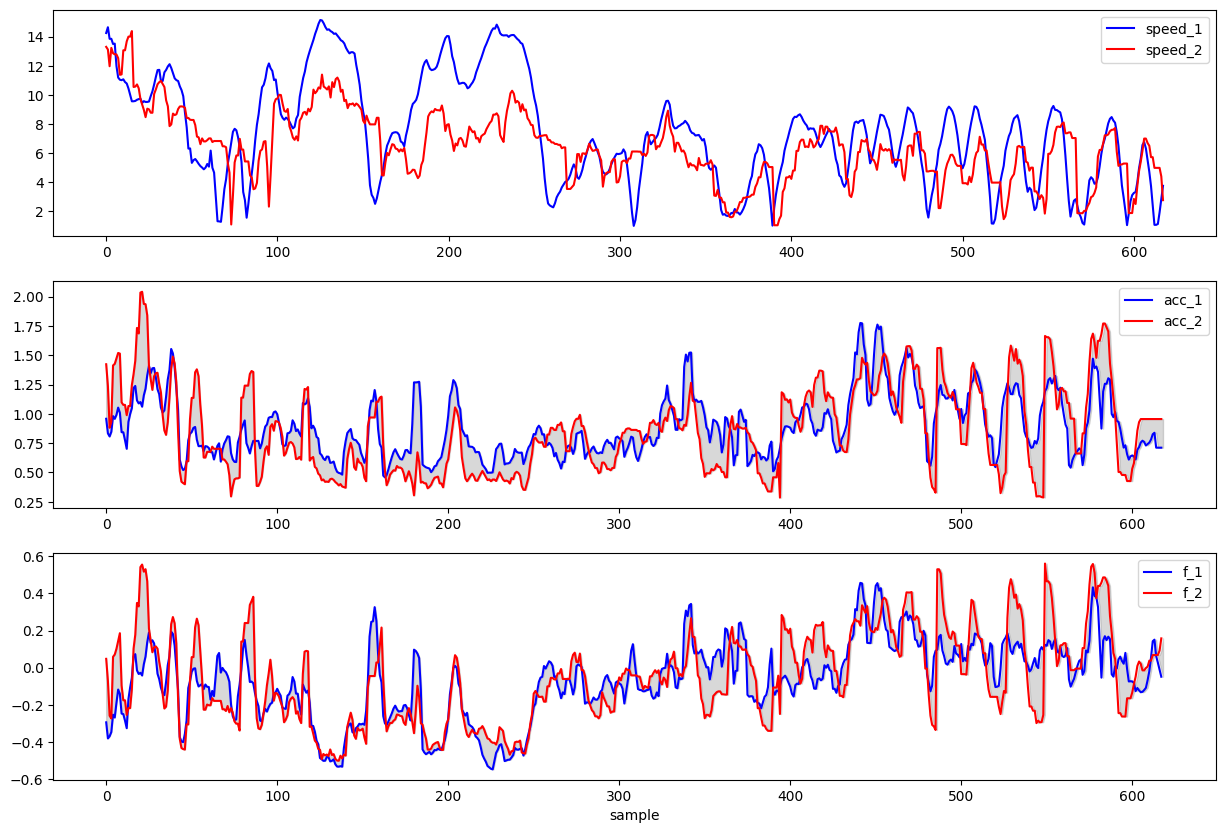

In [33]:
X_equal = np.array([features_lf_1.loc[:, 'speed'].values, features_lf_1.loc[:, 'z_rolling_rms'].values, 
              features_lf_2_matched.loc[:, 'speed'].values, features_lf_2_matched.loc[:, 'z_rolling_rms'].values]).T
y_equal = np.zeros((X_equal.shape[0], 1))

x1_1_pred = model_x1.predict([X_equal[:, :2]])
x1_2_pred = model_x1.predict([X_equal[:, 2:]])

fig, ax = plt.subplots(3, 1, figsize=(15,10))
ax[0].plot(X_equal[:, 0], color='blue', linestyle='-', label='speed_1')
ax[0].plot(X_equal[:, 2], color='red', linestyle='-', label='speed_2')
ax[0].legend()
ax[1].plot(X_equal[:, 1], color='blue', linestyle='-', label='acc_1')
ax[1].plot(X_equal[:, 3], color='red', linestyle='-', label='acc_2')
ax[1].fill_between(np.linspace(0,x1_1_pred.shape[0],x1_1_pred.shape[0]), 
                   (X_equal[:, 1]).ravel(), 
                   (X_equal[:, 3]).ravel(), 
                   color='grey', alpha=0.3)  # Adjust alpha for transparency if needed
ax[1].legend()
ax[2].plot(x1_1_pred, color='blue', linestyle='-', label='f_1')
ax[2].plot(x1_2_pred, color='red', linestyle='-', label='f_2')
ax[2].fill_between(np.linspace(0,x1_1_pred.shape[0],x1_1_pred.shape[0]), 
                   (x1_1_pred).ravel(), 
                   (x1_2_pred).ravel(), 
                   color='grey', alpha=0.3)  # Adjust alpha for transparency if needed
ax[2].legend()
ax[2].set_xlabel('sample')
# ax[3].plot((x1_1_pred+x1_2_pred)/2, color='green', linestyle='-', label='f_m')
# ax[3].fill_between(np.linspace(0,x1_1_pred.shape[0],x1_1_pred.shape[0]), 
#                    (x1_1_pred).ravel(), 
#                    (x1_2_pred).ravel(), 
#                    color='grey', alpha=0.3)  # Adjust alpha for transparency if needed

# ax[3].legend()
# ax[3].set_xlabel('sample')

In [20]:
circ_rad = 10

# Create a map centered at the mean latitude and longitude of loc_orig_df_2
center_lat = loc_orig_df_1['latitude'].mean()
center_lon = loc_orig_df_1['longitude'].mean()
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

f1, f2 = x1_1_pred[:,0], x1_2_pred[:,0]
f1, f2 = f1-np.min(f1), f2-np.min(f2)
f1, f2 = f1/np.max(f1), f2/np.max(f2)

# Plot the latitude and longitude data on the map
for index in range(loc_orig_df_1.shape[0]):
    row1, row2 = loc_orig_df_1.iloc[index,:], loc_orig_df_2_matched.iloc[index,:]
    folium.Circle([row1['latitude'], row1['longitude']],
                        radius=circ_rad*f1[index],
                        color='blue',
                        fill=False,
                        fill_color='blue').add_to(mymap)
    folium.Circle([row2['latitude'], row2['longitude']],
                        radius=circ_rad*f2[index],
                        color='red',
                        fill=False,
                        fill_color='red').add_to(mymap)

# Save the map to an HTML file
mymap.save("map_f.html")



In [21]:
circ_rad = 5

# Create a map centered at the mean latitude and longitude of loc_orig_df_2
center_lat = loc_orig_df_1['latitude'].mean()
center_lon = loc_orig_df_1['longitude'].mean()
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10, tiles='OpenStreetMap')

acc1, acc2 = X_equal[:, 1], X_equal[:, 3]
acc1, acc2 = acc1-np.min(acc1), acc2-np.min(acc2)
acc1, acc2 = acc1/np.max(acc1), acc2/np.max(acc2)

# Plot the latitude and longitude data on the map
for index in range(loc_orig_df_1.shape[0]):
    row1, row2 = loc_orig_df_1.iloc[index,:], loc_orig_df_2_matched.iloc[index,:]
    folium.Circle([row1['latitude'], row1['longitude']],
                        radius=circ_rad*acc1[index],
                        color='blue',
                        fill=False,
                        fill_color='blue').add_to(mymap)
    folium.Circle([row2['latitude'], row2['longitude']],
                        radius=circ_rad*acc2[index],
                        color='red',
                        fill=False,
                        fill_color='red').add_to(mymap)

# Save the map to an HTML file
mymap.save("map_acc.html")

### Correlations

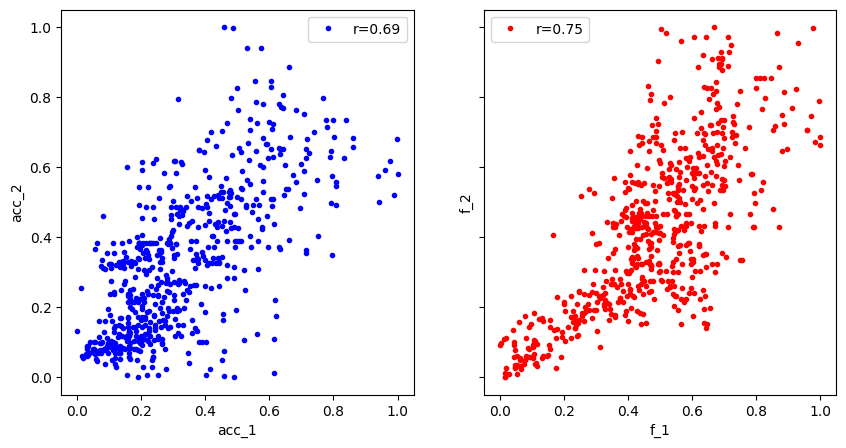

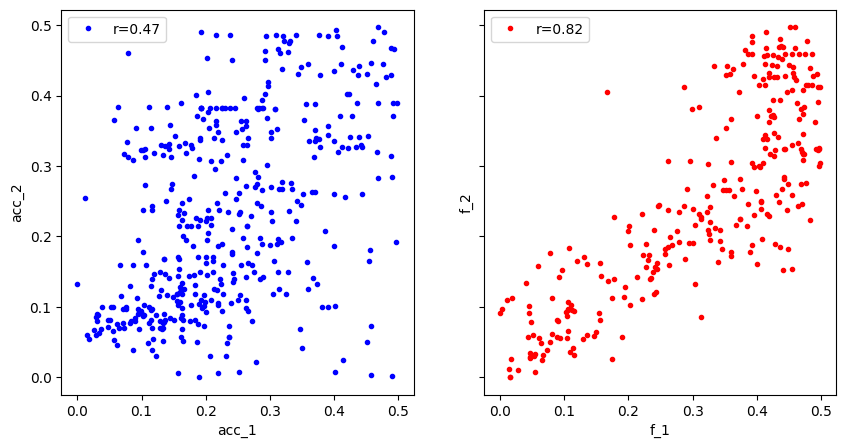

In [22]:
# acceleration correlation
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex='all', sharey=all)
ax[0].plot(acc1, acc2, linestyle='', color='blue', marker='.', label=f'r={np.round(np.corrcoef(acc1, acc2)[1,0], 2)}')
ax[0].set_xlabel('acc_1')
ax[0].set_ylabel('acc_2')
ax[0].legend()
ax[1].plot(f1, f2, linestyle='', color='red', marker='.', label=f'r={np.round(np.corrcoef(f1, f2)[1,0], 2)}')
ax[1].set_xlabel('f_1')
ax[1].set_ylabel('f_2')
ax[1].legend()
plt.show()


# acceleration correlation
acc_low = np.vstack((acc1, acc2)).T
acc_low = acc_low[(acc_low[:, 0] < 0.5) & (acc_low[:, 1] < 0.5), :]
acc1_low, acc2_low = acc_low[:, 0], acc_low[:, 1]
f_low = np.vstack((f1, f2)).T
f_low = f_low[(f_low[:, 0] < 0.5) & (f_low[:, 1] < 0.5), :]
f1_low, f2_low = f_low[:, 0], f_low[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex='all', sharey=all)
ax[0].plot(acc1_low, acc2_low, linestyle='', color='blue', marker='.', label=f'r={np.round(np.corrcoef(acc1_low, acc2_low)[1,0], 2)}')
ax[0].set_xlabel('acc_1')
ax[0].set_ylabel('acc_2')
ax[0].legend()
ax[1].plot(f1_low, f2_low, linestyle='', color='red', marker='.', label=f'r={np.round(np.corrcoef(f1_low, f2_low)[1,0], 2)}')
ax[1].set_xlabel('f_1')
ax[1].set_ylabel('f_2')
ax[1].legend()